# Splitting Pre-Processed Data into Training and Testing Datasets

- Data was imported in raw_data, pre-processed using import_data.ipynb and data_utils.py, and then saved to proc_data folder

- This notebook utilizes the masks created by create_masks.ipynb and saved into create_masks.nc. Both the SOCAT and the network masks were saved into the pre-processed dataset. All training and testing data are filtered for the network mask (approximately open ocean areas) and the SOCAT mask is used to evaluate seen and unseen performance.

- Test months are separated from training and evaluation years like Bennington et al. (2022)

## Paths

In [3]:
# =========================================
# For accessing directories
# =========================================

root_dir = '/home/julias/MLEE-final-project' 
data_output_dir = f'{root_dir}/proc_data'
model_output_dir = f'{root_dir}/models'
#recon_output_dir = f'{root_dir}/models/reconstructions'
#other_output_dir = f'{root_dir}/models/performance_metrics'
#approach = 'XGB'
#approach_output_dir = f"{other_output_dir}/{approach}"
#reference_output_dir = f"{root_dir}/pickle_files" #need to change, won't have full data pickle files on git --> or is this member dict etc only? how done when only ran with 1 model?

#reference_output_dir = f"/data/artemis/workspace/vbennington/full_sst/gregor_years/references"
#jake_other_output_dir = '/data/artemis/workspace/jfs2167/recon_eval/models/performance_metrics'

# =========================================
# Number of cores you have access to for model training
# =========================================
jobs = 30

## Modules

In [5]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle

# Machine learning libraries
#import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
#from sklearn.model_selection import GridSearchCV

# Python file with supporting functions
import proc_utils 

2022-12-31 12:38:27.432092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pre-Processed Data

In [6]:
ens = 'CESM'
member = '009'

In [7]:
# when creating multiple from testbed, will do:
# data_dir = f"{data_output_dir}/{ens}/member_{member}"
# fname = f'proc_data_2D_mon_{ens}_{member}_1x1_198202-201701.nc'
# file_path = f"{data_dir}/{fname}"

# here, project only focuses on CESM Member 009
fname = f'proc_data_2D_mon_{ens}_{member}_1x1_198202-201701.nc'
file_path = f'{data_output_dir}/{fname}'

In [8]:
ds = xr.open_dataset(file_path)
df = ds.to_dataframe()
df

SSS       SST        MLD       Chl        pCO2  \
xlon   ylat  time                                                               
-179.5 -89.5 1982-02-15        NaN       NaN        NaN       NaN         NaN   
             1982-03-15        NaN       NaN        NaN       NaN         NaN   
             1982-04-15        NaN       NaN        NaN       NaN         NaN   
             1982-05-15        NaN       NaN        NaN       NaN         NaN   
             1982-06-15        NaN       NaN        NaN       NaN         NaN   
...                            ...       ...        ...       ...         ...   
 179.5  89.5 2016-09-15  31.799175 -1.705077  18.321320  2.740259  262.587131   
             2016-10-15  31.790358 -1.793757  23.279984  0.999385  305.656131   
             2016-11-15  31.931990 -1.799327  33.931915  0.045596  339.048261   
             2016-12-15  32.034790 -1.801694  46.475067  0.021913  359.252983   
             2017-01-15  32.136246 -1.800700  57.481308  0.014401  379.529046   

                         socat_mask  net_mask        XCO2        T0        T1  \
xlon   ylat  time                                                               
-179.5 -89.5 1982-02-15         NaN       NaN  340.848541  0.702527  0.711657   
             1982-03-15         NaN       NaN  340.962250  0.292600  0.956235   
             1982-04-15         NaN       NaN  341.075439 -0.234491  0.972118   
             1982-05-15         NaN       NaN  341.193176 -0.683919  0.729558   
             1982-06-15         NaN       NaN  341.310730 -0.959933  0.280231   
...                             ...       ...         ...       ...       ...   
 179.5  89.5 2016-09-15         NaN       NaN  406.045654 -0.251190 -0.967938   
             2016-10-15         NaN       NaN  406.276947  0.259512 -0.965740   
             2016-11-15         NaN       NaN  406.508392  0.714673 -0.699458   
             2016-12-15         NaN       NaN  406.739502  0.966848 -0.255353   
             2017-01-15         NaN       NaN  406.971283  0.966848  0.255353   

                                A         B         C  
xlon   ylat  time                                      
-179.5 -89.5 1982-02-15 -0.999962 -0.000076  0.008726  
             1982-03-15 -0.999962 -0.000076  0.008726  
             1982-04-15 -0.999962 -0.000076  0.008726  
             1982-05-15 -0.999962 -0.000076  0.008726  
             1982-06-15 -0.999962 -0.000076  0.008726  
...                           ...       ...       ...  
 179.5  89.5 2016-09-15  0.999962  0.000076  0.008726  
             2016-10-15  0.999962  0.000076  0.008726  
             2016-11-15  0.999962  0.000076  0.008726  
             2016-12-15  0.999962  0.000076  0.008726  
             2017-01-15  0.999962  0.000076  0.008726  

[27216000 rows x 13 columns]

## If chose to track seeds:

In [ ]:
# Loading references
# This is exactly the same as in 01_datasets_LET

#path_LET = f"{reference_output_dir}/members_LET_dict.pickle"
path_seeds = f"{reference_output_dir}/random_seeds.npy"
path_loc = f"{reference_output_dir}/members_seed_loc_dict.pickle"

#with open(path_LET,'rb') as handle:
#    mems_dict = pickle.load(handle)
    
random_seeds = np.load(path_seeds)    
    
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)

In [ ]:
#seed_loc = seed_loc_dict[ens][member] #think can comment out line, just define CESM 009 above
#print(ens) #think can comment out line, just define CESM 009 above
#print(member) #think can comment out line, just define CESM 009 above
#seed_loc

In [ ]:
#random_seeds

In [ ]:
#mems_dict

In [ ]:
#seed_loc_dict

## Printing Best Params from other pCO2_Residual Run (Bennington 2022?)

In [ ]:
# This is just showing the best parameters from another pCO2-Residual run (the ones that give the lowest RMSE)
# 4000 n_estimators and 6 levels
# n_estimators: 4000 decision trees
# levels: defining the decision trees (number of splits)

path_bp="/data/artemis/workspace/vbennington/full_sst/pCO2_DIC/models/performance_metrics/xg/xg_best_params_dict.pickle"
with open(path_bp,'rb') as handle:
    best_params = pickle.load(handle)
print(best_params)

#### Parameter grids

In [ ]:
# Test with three different n_estimators and 3 different depths
# NB: For XGB, too many depth layers may lead to overfitting (usually 8 or less layers for XGB)
# We want the combo of xg_param_grid that gives the lowest RMSE

xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4, 5, 6]}

## Feature and Target Lists 

for feeding into the models (and masking during training/testing split)

In [9]:
# A, B and C represent lon and lat (3 components of the n-vector; so that the algorithm doesn't interpret 0 and 360
# degrees to be far apart 
# T0 and T1 represent time

features_sel = ['SSS','SST','MLD','Chl','XCO2','T0', 'T1','A', 'B', 'C'] 
target_sel = ['pCO2'] 

# Split into Training and Testing Sets

## Define Training/Testing Date Lists for Split

In [10]:
df['year'] = df.index.get_level_values('time').year 
df['mon'] = df.index.get_level_values('time').month 
df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str) 
df

SSS       SST        MLD       Chl        pCO2  \
xlon   ylat  time                                                               
-179.5 -89.5 1982-02-15        NaN       NaN        NaN       NaN         NaN   
             1982-03-15        NaN       NaN        NaN       NaN         NaN   
             1982-04-15        NaN       NaN        NaN       NaN         NaN   
             1982-05-15        NaN       NaN        NaN       NaN         NaN   
             1982-06-15        NaN       NaN        NaN       NaN         NaN   
...                            ...       ...        ...       ...         ...   
 179.5  89.5 2016-09-15  31.799175 -1.705077  18.321320  2.740259  262.587131   
             2016-10-15  31.790358 -1.793757  23.279984  0.999385  305.656131   
             2016-11-15  31.931990 -1.799327  33.931915  0.045596  339.048261   
             2016-12-15  32.034790 -1.801694  46.475067  0.021913  359.252983   
             2017-01-15  32.136246 -1.800700  57.481308  0.014401  379.529046   

                         socat_mask  net_mask        XCO2        T0        T1  \
xlon   ylat  time                                                               
-179.5 -89.5 1982-02-15         NaN       NaN  340.848541  0.702527  0.711657   
             1982-03-15         NaN       NaN  340.962250  0.292600  0.956235   
             1982-04-15         NaN       NaN  341.075439 -0.234491  0.972118   
             1982-05-15         NaN       NaN  341.193176 -0.683919  0.729558   
             1982-06-15         NaN       NaN  341.310730 -0.959933  0.280231   
...                             ...       ...         ...       ...       ...   
 179.5  89.5 2016-09-15         NaN       NaN  406.045654 -0.251190 -0.967938   
             2016-10-15         NaN       NaN  406.276947  0.259512 -0.965740   
             2016-11-15         NaN       NaN  406.508392  0.714673 -0.699458   
             2016-12-15         NaN       NaN  406.739502  0.966848 -0.255353   
             2017-01-15         NaN       NaN  406.971283  0.966848  0.255353   

                                A         B         C  year  mon year_month  
xlon   ylat  time                                                            
-179.5 -89.5 1982-02-15 -0.999962 -0.000076  0.008726  1982    2     1982-2  
             1982-03-15 -0.999962 -0.000076  0.008726  1982    3     1982-3  
             1982-04-15 -0.999962 -0.000076  0.008726  1982    4     1982-4  
             1982-05-15 -0.999962 -0.000076  0.008726  1982    5     1982-5  
             1982-06-15 -0.999962 -0.000076  0.008726  1982    6     1982-6  
...                           ...       ...       ...   ...  ...        ...  
 179.5  89.5 2016-09-15  0.999962  0.000076  0.008726  2016    9     2016-9  
             2016-10-15  0.999962  0.000076  0.008726  2016   10    2016-10  
             2016-11-15  0.999962  0.000076  0.008726  2016   11    2016-11  
             2016-12-15  0.999962  0.000076  0.008726  2016   12    2016-12  
             2017-01-15  0.999962  0.000076  0.008726  2017    1     2017-1  

[27216000 rows x 16 columns]

#### Make lists for training and test sets

In [11]:
select_dates = [] # Training set (this will be split in validation and another training set)
test_dates = []   # Test set 

#### Define date vector range of dataset

In [12]:
date_range_start = '1982-02' 
date_range_end = '2017-01'

In [13]:
df.index.get_level_values('time').min()

Timestamp('1982-02-15 00:00:00')

In [14]:
# MS: beginning of each month + 14 --> each month starts on the 15th #again, why

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [15]:
dates

DatetimeIndex(['1982-02-15', '1982-03-15', '1982-04-15', '1982-05-15',
               '1982-06-15', '1982-07-15', '1982-08-15', '1982-09-15',
               '1982-10-15', '1982-11-15',
               ...
               '2016-04-15', '2016-05-15', '2016-06-15', '2016-07-15',
               '2016-08-15', '2016-09-15', '2016-10-15', '2016-11-15',
               '2016-12-15', '2017-01-15'],
              dtype='datetime64[ns]', length=420, freq=None)

#### Want to train with 4 out of every 5 months, and test on the fifth month

In [16]:
# i % 5 != 0: i cannot be divided by 5 without resulting in a remainder (will not give 0, i.e., i is not divisible by 5)
# i % ==0: i can be divided by 5 without resulting in a remainder. i is divisible by 5

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) #training set. train on all months but the 5th
    if i % 5 == 0:
        test_dates.append(dates[i])   #testing set. test on the 5th month

#### Split dates of training set into year and month

In [17]:
year_mon = [] #making a list for the training set

for i in range(0,len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}") #what is tmp/do i need to create that?

#### Split dates of test set into year and month

In [18]:
test_year_mon = [] #making a list for the test set

for i in range(0,len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

In [ ]:
# year_mon

In [ ]:
# len(year_mon)

In [ ]:
# test_year_mon

In [ ]:
# len(test_year_mon)

## Define Mask Locations for Split

Based on Training/Testing Dates, Network Mask (Open Ocean), and SOCAT Points

### Unmasked Locations

"Unmasked" locations are still filtered for network mask (approximately open ocean) and reasonable pCO2 values

In [19]:
df.pCO2.min()

108.47248047369489

In [20]:
df.pCO2.max()

814.133112759736

<AxesSubplot: xlabel='xlon,ylat,time'>

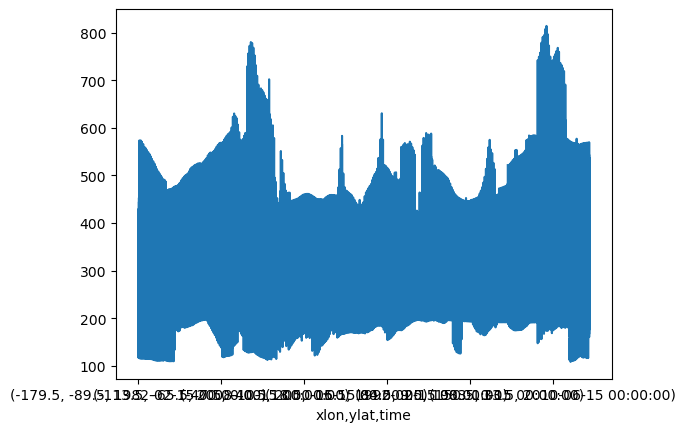

In [21]:
df.pCO2.plot()

In [22]:
# See create_mask.ipynb for full explanation of network mask
# Range 150 to 650: reasonable pCO2 values
# Features_sel: SST, SSS, MLD etc 
# Target_sel: pCO2

recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & ((df[target_sel] < 650) 
                                                        & (df[target_sel] > 150)).to_numpy().ravel()

In [23]:
recon_sel

xlon    ylat   time      
-179.5  -89.5  1982-02-15    False
               1982-03-15    False
               1982-04-15    False
               1982-05-15    False
               1982-06-15    False
                             ...  
 179.5   89.5  2016-09-15    False
               2016-10-15    False
               2016-11-15    False
               2016-12-15    False
               2017-01-15    False
Length: 27216000, dtype: bool

### Masked Locations

#### "Seen" Masked Locations

Seen "masked" locations are filtered for both unmasked locations {to remove network mask (approximately open ocean) and reasonable pCO2 values} and SOCAT sampling points

In [31]:
sel = (recon_sel & (df['socat_mask'] == 1))

In [32]:
sel

xlon    ylat   time      
-179.5  -89.5  1982-02-15    False
               1982-03-15    False
               1982-04-15    False
               1982-05-15    False
               1982-06-15    False
                             ...  
 179.5   89.5  2016-09-15    False
               2016-10-15    False
               2016-11-15    False
               2016-12-15    False
               2017-01-15    False
Length: 27216000, dtype: bool

#### "Unseen" Masked Locations

Unseen "masked" locations are filtered for unmasked locations {to remove network mask (approximately open ocean) and reasonable pCO2 values} with SOCAT sampling points removed

In [34]:
unseen_sel = (recon_sel & (np.isnan(df['socat_mask']))) 

In [35]:
unseen_sel

xlon    ylat   time      
-179.5  -89.5  1982-02-15    False
               1982-03-15    False
               1982-04-15    False
               1982-05-15    False
               1982-06-15    False
                             ...  
 179.5   89.5  2016-09-15    False
               2016-10-15    False
               2016-11-15    False
               2016-12-15    False
               2017-01-15    False
Length: 27216000, dtype: bool

#### Make sure not to train and test on same data

In [36]:
# for the TRAINING - makes sure to pick year + month from CESM data ('year_month') that is not 
# in the 5th month (defined by year_mon in cell earlier)  
train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
print(sum(train_sel))

198577


In [37]:
# for the TESTING - makes sure to pick year + month from LET data ('year_month') that is  
# in the 5th month (defined by test_year_mon in cell earlier).
test_sel = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
print(sum(test_sel))

47610


## Split Datasets

### Referencing Group Methods

#### If chose to track seeds:

In [ ]:
# Loading references
# This is exactly the same as in 01_datasets_LET

reference_output_dir = '/home/julias/MLEE-final-project/pickle_files'
#path_LET = f"{reference_output_dir}/members_LET_dict.pickle"
path_seeds = f'{reference_output_dir}/random_seeds.npy'
path_loc = f'{reference_output_dir}/members_seed_loc_dict.pickle'

#with open(path_LET,'rb') as handle:
#    mems_dict = pickle.load(handle)
    
random_seeds = np.load(path_seeds)    
    
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)

In [ ]:
seed_loc = seed_loc_dict[ens][member] #think can comment out line, just define CESM 009 above
#print(ens) #think can comment out line, just define CESM 009 above
#print(member) #think can comment out line, just define CESM 009 above
#seed_loc


cesm_members_dict

In [ ]:
#random_seeds

In [ ]:
#mems_dict

In [ ]:
#seed_loc_dict

#### Printing Best Params from other pCO2_Residual Run (Bennington 2022?)

In [ ]:
# This is just showing the best parameters from another pCO2-Residual run (the ones that give the lowest RMSE)
# 4000 n_estimators and 6 levels
# n_estimators: 4000 decision trees
# levels: defining the decision trees (number of splits)

path_bp="/data/artemis/workspace/vbennington/full_sst/pCO2_DIC/models/performance_metrics/xg/xg_best_params_dict.pickle"
with open(path_bp,'rb') as handle:
    best_params = pickle.load(handle)
print(best_params)

In [ ]:
# Test with three different n_estimators and 3 different depths
# NB: For XGB, too many depth layers may lead to overfitting (usually 8 or less layers for XGB)
# We want the combo of xg_param_grid that gives the lowest RMSE

xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4, 5, 6]}

### Train/validate/test split proportions

In [ ]:
# 20% of dataset for validation, 20% of dataset for testing, the rest for training
# Training set will be split into validation and another training set

val_prop = .2
test_prop = .2

### Create two dictionaries

In [ ]:
# best_params = {}  # opened above
# defaultdict is from a package #which one, does what

test_performance = defaultdict(dict)
unseen_performance = defaultdict(dict)

### Split datasets, convert dataframe to numpy arrays

In [38]:
# Train/val/test split ALL of the data (FULL dataset)
X = df.loc[sel,features_sel].to_numpy()         
y = df.loc[sel,target_sel].to_numpy().ravel()    

In [39]:
# Selecting training and validation sets
Xtrain = df.loc[train_sel,features_sel].to_numpy() # create Xtrain and Xtest to randomly select from for X_train and X_test
ytrain = df.loc[train_sel,target_sel].to_numpy().ravel()

In [ ]:
# Splitting the training data into validation and another training set   
N = Xtrain.shape[0]
train_val_idx, train_idx, val_idx, test_idx = proc_utils.train_val_test_split(N, test_prop, val_prop, random_seeds, seed_loc)
X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = pre_saildrone_thea.apply_splits(Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx) 

In [ ]:
# We don't use X_test_tmp or y_test_tmp when test years are used (X_test and y_test set above)
X_test = df.loc[test_sel,features_sel].to_numpy()  #  Test metrics on all of SOCAT data from test years
y_test = df.loc[test_sel,target_sel].to_numpy().ravel()

In [ ]:
# WHAT DOES "we don't use X_test_tmp etc when test years are used mean?

### XGB-Specific Inputs

In [ ]:
# K_folds: cross validation; number of splits for training set (in this case 3 splits; see below)
# Train on the first split, test on the remaining 2. Total 3 numbers for the final RMSE

K_folds = 3       # Split training set into 3 parts
approach = "xg"   # XGB approach
first_mem = False # Initialize if using gridsearch to find best_params

### Train the XBG model

In [ ]:
model = XGBRegressor(random_state=random_seeds[5,seed_loc], **best_params[ens], n_jobs=jobs)
model.fit(X_train_val, y_train_val) 

### Save the XBG model

In [ ]:
#Uncomment when actually running

# pre_saildrone now called utils, carry through this change
utils.save_model(model, model_output_dir, approach, ens, member)
print(datetime.datetime.now())
print(ens)
print(member)

### Preliminary Analysis on XBG Test Error Metrics

In [ ]:
# Calculate some test error metrics and store in a dictionary
# evaluate_test is a function from pre_saildrone. it includes MSE, MAE, bias etc

y_pred_test = model.predict(X_test)

test_performance[ens][member] = utils.evaluate_test(y_test, y_pred_test)
print(test_performance[ens][member])

In [ ]:
# Redo this analysis on the unseen data
y_pred_unseen = model.predict(df.loc[unseen_sel,features_sel].to_numpy())

y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = utils.evaluate_test(y_unseen, y_pred_unseen)
print(unseen_performance[ens][member])

## Create the reconstruction

In [ ]:
# Create the reconstruction and save it
# Jake calls it seen
# This should just be all SOCAT locations for all training years (not test years)
y_pred_seen = model.predict(X)

In [ ]:
# Full reconstruction 
df['pCO2_DIC_recon'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_recon']] = y_pred_unseen   # Not in a SOCAT location, not even in test year
df.loc[sel,['pCO2_DIC_recon']] = y_pred_seen

In [ ]:
# All time/locations not sampled by SOCAT
df['pCO2_DIC_nosocat'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_nosocat']] = y_pred_unseen
df.loc[sel,['pCO2_DIC_nosocat']] = np.nan

In [ ]:
# Only at time/locations of SOCAT sampling
df['pCO2_DIC_socat'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_socat']] = np.nan
df.loc[sel,['pCO2_DIC_socat']] = y_pred_seen
     
df['pCO2_DIC'] = df['pCO2_pCO2T_diff']
             
#DS_recon = df[['net_mask','socat_mask','pCO2_DIC','pCO2_DIC_recon','pCO2_DIC_socat','pCO2_DIC_nosocat']].to_xarray()
DS_recon = df[['net_mask','combined_mask','pCO2_DIC','pCO2_DIC_recon','pCO2_DIC_socat','pCO2_DIC_nosocat']].to_xarray()

## Save reconstructions

In [ ]:
# Uncomment when actually running            
#pre_saildrone_thea.save_recon(DS_recon, recon_output_dir, approach, ens, member)   

## Save best parameters and performance metrics

In [ ]:
# Saving best parameters and performance metrics

approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
test_perform_fname = f"{approach_output_dir}/{approach}_test_performance_dict.pickle"
unseen_perform_fname = f"{approach_output_dir}/{approach}_unseen_performance_dict.pickle"

Path(approach_output_dir).mkdir(parents=True, exist_ok=True)

with open(param_fname, 'wb') as handle: #WHAT DOES wb MEAN
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(test_perform_fname, 'wb') as handle:
    pickle.dump(test_performance, handle)
with open(unseen_perform_fname, 'wb') as handle:
    pickle.dump(unseen_performance, handle)
    
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]
                                  for i in test_performance.keys()
                                  for j in test_performance[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]
                                  for i in unseen_performance.keys()
                                  for j in unseen_performance[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)    

In [ ]:
#just checking what the saved trained datafiles look like 
test_2 = pd.read_pickle("/data/artemis/workspace/theimdal/saildrone/models/trained/xg/CESM/member_016/xg_model_pC02_2D_mon_CESM_016_1x1_198201-201701.joblib")

In [ ]:
test_2

In [ ]:
#checking out what the input data for the XGB looks like
#this table was generated in script 01
df